# Understanding Noise Estimators
In this notebook, we explore the basics of error mitigation using IBM Qiskit.

Resources:
- [1] [IBM Qiskit Tutorial](https://learning.quantum.ibm.com/course/utility-scale-quantum-computing/lesson-11-error-mitigation)

In [34]:
# import packages
import numpy as np

import qiskit_aer.noise as noise
from qiskit_aer.noise.errors import coherent_unitary_error, amplitude_damping_error, ReadoutError
from qiskit.circuit.library import RXGate

from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp

In [55]:
# create the test circuits
circuits = []

MAX_DEPTH = 100
for depth in range(MAX_DEPTH):
	
	circuit = QuantumCircuit(1)
	for _ in range(depth):
		circuit.x(0)
	circuit.measure_all()
	circuits.append(circuit)
	

## Baseline
We first obtain results sans error mitigation using a simulated noise model.
In this case, we will test a custom noise model.
In experimental settings, the range of possible errors (and variety of circumstances) that would impact the final read out results of the circuit are wide-ranging.
Since we are testing only x-gates, we can constrain the classes of errors that occur.

In our noise model, we add the following errors:
- Coherent unitary error: Describes the degree (angle) by which the gate applied differs from the expected rotation. The RX-gate can be visualized as a rotation around the X-axis on the Bloch sphere. This type of error manifests as an under or over-rotation and is known as a type of coherent error, because the error still respects unitary evolution (i.e. is not an angular rotation in the Y or Z directions).
- Amplitude damping error: Consider a single qubit. The "1" state is known as the excited state, while the "0" state is known as the ground state. An amplitude damping occurs when the energy of the qubit dissipates, resulting in a gradual transition from the excited to ground states. The "amplitude" refers to the magnitude of excitement the qubit is in.
- Read-out error: These errors occur at the measurement stage of the qubit. These errors can arise as a result of a number of factors, such as overlapping probability distributions or imperfect measurement operations (i.e. noise in the measurement apparatus). Since we have only 1 qubit, the matrix we pass the error in as is equivalent to a confusion matrix for a binary variable.

In [37]:
# custom build the noise model
noise_model = noise.NoiseModel()

# set up the error functions
prob_1 = 1e-3
prob_2 = 1e-2

# error function for single qubit gate
error_1 = noise.depolarizing_error(prob_1, 1)
# # error function for two-qubit gate
# error_2 = noise.depolarizing_error(prob_2, 2)

# add rotational error
angle = 0.05
coherent_error = coherent_unitary_error(RXGate(angle).to_matrix())

# add amplitude damping error
ad_param = 0.02
incoherent_error = amplitude_damping_error(ad_param)

# readout error
error_0 = 0.03
error_1 = 0.08

# convert to matrix
readout_error = ReadoutError([
    [1 - error_0, error_0],
    [error_1, 1 - error_1]
])

# add errors to noise model qubit 0
noise_model.add_quantum_error(coherent_error.compose(incoherent_error), 'x', (0, ))
noise_model.add_readout_error(readout_error, (0, ))

In [38]:
# construct the sampler
noisy_sampler = Sampler(options={
    'backend_options': {
        'noise_model': noise_model
	}
})

In [27]:
# define measurement basis
obs = SparsePauliOp.from_list([("Z", 1.0)])

In [56]:
# run on noisy sampler
job = noisy_sampler.run(circuits, shots=400)
result = job.result()

In [59]:
result[0].data.meas.get_counts()

{'0': 391, '1': 9}

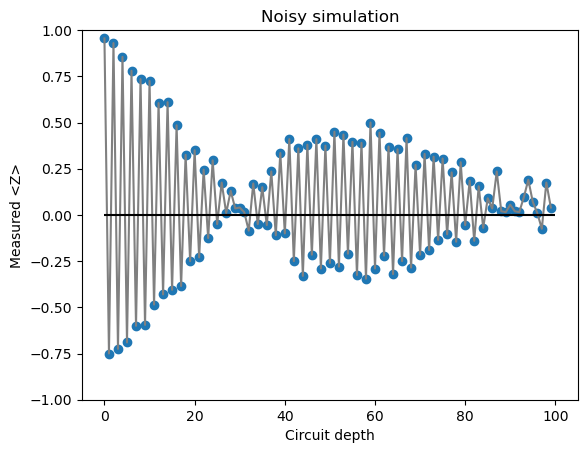

In [65]:
import matplotlib.pyplot as plt
plt.title(f"Noisy simulation")
ds = list(range(MAX_DEPTH))

plt.plot(ds, [result[d].data.meas.expectation_values(["Z"]) for d in ds], color="gray", linestyle="-",)
plt.scatter(ds, [result[d].data.meas.expectation_values(["Z"]) for d in ds], marker="o")
plt.hlines(0, xmin=0, xmax=MAX_DEPTH, colors="black")
plt.ylim(-1, 1)
plt.xlabel("Circuit depth")
plt.ylabel("Measured <Z>")
plt.show()

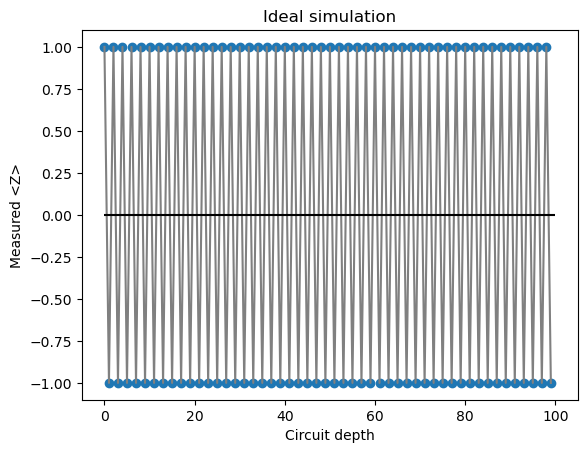

In [68]:
ideal_sampler = Sampler()
job_ideal = ideal_sampler.run(circuits)
result_ideal = job_ideal.result()
plt.title(f"Ideal simulation")
ds = list(range(MAX_DEPTH))
plt.plot(ds, [result_ideal[d].data.meas.expectation_values(["Z"]) for d in ds], color="gray", linestyle="-",)
plt.scatter(ds, [result_ideal[d].data.meas.expectation_values(["Z"]) for d in ds], marker="o")
plt.hlines(0, xmin=0, xmax=MAX_DEPTH, colors="black")
plt.xlabel("Circuit depth")
plt.ylabel("Measured <Z>")
plt.show()

In [2]:
from qiskit import QuantumCircuit

c = QuantumCircuit(4)
c.x(list(range(4)))
c.measure_all()
c.draw()

┌───┐ ░ ┌─┐         
   q_0: ┤ X ├─░─┤M├─────────
        ├───┤ ░ └╥┘┌─┐      
   q_1: ┤ X ├─░──╫─┤M├──────
        ├───┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ X ├─░──╫──╫─┤M├───
        ├───┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ X ├─░──╫──╫──╫─┤M├
        └───┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════╩══╩══╩══╩═
                 0  1  2  3